# World Data League 2022

## 🎯 Challenge

Predict Waste Production for its Reduction 🌏🗑♻


## 👥 Authors
* Natascia Caria
* Claudia Cozzolino
* Alfredo Petrella

## 💻 Development


### Notebook Setup

In [ ]:
!pip install meteostat pmdarima osmium shapely

In [ ]:
#################
# Load libraries
#################
import os
import sys
import logging
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import meteostat as ms
import pmdarima
from sklearn.preprocessing import MinMaxScaler

import statsmodels
from google.colab import drive

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.wkt
import osmium


In [ ]:
# Logging config
logging.basicConfig(
    format='%(asctime)s | %(levelname)s : %(message)s',
    level=logging.INFO, stream=sys.stdout
)

In [ ]:
'''
# Point Colaboratory to My Drive
drive.mount('/content/gdrive/')
'''

In [ ]:
################
# Working paths
################
mainPath = ''
dataPath = os.path.join(mainPath, "data")

# Set mainPath as working directory
os.chdir(mainPath)
logging.info(f"Working directory\n {os.getcwd()}\n")

# Data saving folder
dataPath = os.path.join(mainPath, "data")
if not os.path.exists(dataPath):
    os.makedirs("data")
    logging.info(f"Data storage directory created")
logging.info(f"Data storage directory\n {dataPath}\n")

### Austin Waste Collection

#### Import available resources



```
!wget https://data.austintexas.gov/api/views/mbnu-4wq9/rows.csv \
    -O data/austin_waste_collection.csv
```



#### Data preprocessing

In [ ]:
###############
# Load Dataset
###############
austin_waste_collection = "austin_waste_collection.csv"
df_austin_waste = pd.read_csv(os.path.join(dataPath, austin_waste_collection))
print(df_austin_waste.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740873 entries, 0 to 740872
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Report Date   740873 non-null  object 
 1   Load Type     740873 non-null  object 
 2   Load Time     740873 non-null  object 
 3   Load Weight   668538 non-null  float64
 4   Dropoff Site  740873 non-null  object 
 5   Route Type    740873 non-null  object 
 6   Route Number  740873 non-null  object 
 7   Load ID       740873 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 45.2+ MB
None


In [ ]:
# Number of rows and columns
nrows_origin, ncols_origin = df_austin_waste.shape
nrows, ncols = nrows_origin, ncols_origin
print(f"Number of rows:\t\t{nrows}")
print(f"Number of columns:\t{ncols}")

Number of rows:		740873
Number of columns:	8


In [ ]:
# Columns name converter: lower case and raplace space with underscore to easier access them
columns_name_converter  = lambda x: x.lower().replace(' ', '_')
df_austin_waste.columns = list(map(columns_name_converter, df_austin_waste.columns))

##### Columns type

In [ ]:
# Convert "report_date" and "load_time" to datetime
df_austin_waste.loc[:, "report_date"] = pd.to_datetime(
    df_austin_waste.loc[:, "report_date"], format="%m/%d/%Y"
)

df_austin_waste.loc[:, "load_time"]   = pd.to_datetime(
    df_austin_waste.loc[:, "load_time"],   format="%m/%d/%Y %I:%M:%S %p"
)

In [ ]:
# Convert "load_weight" to numeric
string_to_numeric_converter = lambda x: x.replace(',', '') if type(x)==str else x
df_austin_waste.loc[:, "load_weight"] = list(map(string_to_numeric_converter, df_austin_waste.loc[:, "load_weight"]))
df_austin_waste.loc[:, "load_weight"] = pd.to_numeric(df_austin_waste.loc[:, "load_weight"])

In [ ]:
# Show columns data type
df_austin_waste.dtypes

report_date     datetime64[ns]
load_type               object
load_time       datetime64[ns]
load_weight            float64
dropoff_site            object
route_type              object
route_number            object
load_id                  int64
dtype: object

##### Duplicates

There are 3 rows occurring 2 times in the dataframe:

In [ ]:
df_austin_waste.loc[df_austin_waste.duplicated(keep=False)]

,report_date,load_type,load_time,load_weight,dropoff_site,route_type,route_number,load_id
147843,2015-06-13,YARD TRIMMING,2015-06-13 14:53:00,7660.0,HORNSBY BEND,YARD TRIMMINGS,YF10,657170
147844,2015-06-13,YARD TRIMMING,2015-06-13 14:53:00,7660.0,HORNSBY BEND,YARD TRIMMINGS,YF10,657170
428788,2015-02-13,MULCH,2015-02-13 10:54:00,11740.0,HORNSBY BEND,HAULING,BRAKER SITE,642844
428789,2015-02-13,MULCH,2015-02-13 10:54:00,11740.0,HORNSBY BEND,HAULING,BRAKER SITE,642844
471822,2009-08-25,SWEEPING,2009-08-25 10:30:00,NaN,ONION CREEK,STREET CLEANING-RESIDENTIAL,C01-R,338258
471823,2009-08-25,SWEEPING,2009-08-25 10:30:00,NaN,ONION CREEK,STREET CLEANING-RESIDENTIAL,C01-R,338258


As these are probably errors, we decide to remove the duplicate rows

In [ ]:
df_austin_waste.drop_duplicates(keep='first', inplace=True)

# Number of rows and columns
nrows, ncols = df_austin_waste.shape
print(f"Number of rows in the original data:\t{nrows_origin}")
print(f"Number of rows after preprocessing:\t{nrows}")
print(f"Total number of removed rows:\t{nrows_origin - nrows}")

Number of rows in the original data:	740873
Number of rows after preprocessing:	740870
Total number of removed rows:	3


##### Nan values

The only column with Nan values is "load_weight":

In [ ]:
# Any nan in data columns
print(f"Column\t\tHas Nan")
print(df_austin_waste.isna().any())

Column		Has Nan
report_date     False
load_type       False
load_time       False
load_weight      True
dropoff_site    False
route_type      False
route_number    False
load_id         False
dtype: bool


In [ ]:
# Number of NaN rows
nan_mask = df_austin_waste.load_weight.isna()
nrows_nan = df_austin_waste.loc[nan_mask].shape[0]

print(f"Number of rows with Nan:\t{nrows_nan} / {nrows}")
print(f"Percentage of rows with Nan:\t{nrows_nan/nrows*100:.2f}%")

Number of rows with Nan:	72334 / 740870
Percentage of rows with Nan:	9.76%


Looking at the distribution of load types across the NaN values, we see that more than 99.5% of the NaN values come from the "SWEEPING" load_type.

In [ ]:
# Percentage of data per load type among the Nan rows
nan_data_per_load_type = df_austin_waste.loc[nan_mask].groupby("load_type").size()
print(nan_data_per_load_type / nrows_nan * 100)

load_type
BRUSH                           0.031797
BULK                            0.004147
DEAD ANIMAL                     0.008295
GARBAGE COLLECTIONS             0.052534
LITTER                          0.053917
MIXED LITTER                    0.092626
ORGANICS                        0.022120
RECYCLING - COMINGLE            0.012442
RECYCLING - PAPER               0.009677
RECYCLING - SINGLE STREAM       0.055299
SWEEPING                       99.593552
TIRES                           0.038709
YARD TRIMMING                   0.023502
YARD TRIMMING - X-MAS TREES     0.001382
dtype: float64


In [ ]:
# Percentage of Nan load weight values per load type
df_austin_waste["isna_load_weight"] = df_austin_waste.load_weight.isna()
load_type_groups = df_austin_waste.groupby(
    ["load_type", "isna_load_weight"]
).size().reset_index(name='count')
load_type_groups["percentage"] = load_type_groups["count"] / load_type_groups.groupby('load_type')['count'].transform('sum') * 100
df_austin_waste.drop('isna_load_weight', axis=1, inplace=True)

fig = px.bar(
    load_type_groups, x="load_type", y="percentage", color="isna_load_weight", barmode="group",
    labels={"isna_load_weight": "load weight is Nan", "load_type": "load type"},
    title="Percentage of (not) Nan per load type"
)
fig.show()

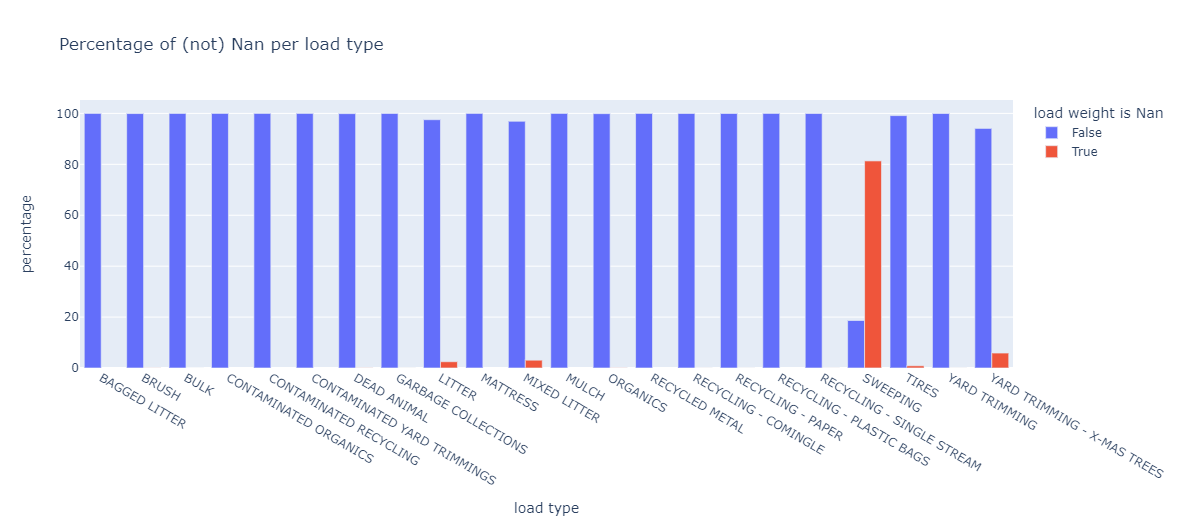

In [ ]:
# Percentage of Nan load weight values per load type
pd.pivot(
    load_type_groups, index='load_type', columns='isna_load_weight', values='percentage'
).fillna(0)

isna_load_weight,False,True
load_type,,
BAGGED LITTER,100.000000,0.000000
BRUSH,99.941273,0.058727
BULK,99.992522,0.007478
CONTAMINATED ORGANICS,100.000000,0.000000
CONTAMINATED RECYCLING,100.000000,0.000000
CONTAMINATED YARD TRIMMINGS,100.000000,0.000000
DEAD ANIMAL,99.912562,0.087438
GARBAGE COLLECTIONS,99.985296,0.014704
LITTER,97.528517,2.471483


##### Data consistency

###### Load weight non-negativity

The values of "load_weight" should all be non-negative, if not Nan.
However here we see a negative value, maybe a typo (?)

In [ ]:
df_austin_waste.loc[df_austin_waste.load_weight<0,]

,report_date,load_type,load_time,load_weight,dropoff_site,route_type,route_number,load_id
3219,2011-09-05,RECYCLING - SINGLE STREAM,2011-09-06,-4480.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMBU23,509539


Looking at the data in a load_time neighbourhood of the row with negative load weight, among the data with the same route number, we see that there is a row with the same load weight but positive.

In [ ]:
df_austin_waste.loc[
    (df_austin_waste.load_time.between("2011-09-01", "2011-09-15")) &
    (df_austin_waste.route_number=="RMBU23"),
].sort_values("load_time")

,report_date,load_type,load_time,load_weight,dropoff_site,route_type,route_number,load_id
358851,2011-09-05,RECYCLING - SINGLE STREAM,2011-09-05 00:00:00,4480.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMBU23,506360
601570,2011-09-05,RECYCLING - SINGLE STREAM,2011-09-05 10:58:00,12360.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMBU23,501214
126126,2011-09-05,RECYCLING - SINGLE STREAM,2011-09-05 13:32:00,4760.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMBU23,501231
3219,2011-09-05,RECYCLING - SINGLE STREAM,2011-09-06 00:00:00,-4480.0,TDS - MRF,RECYCLING - SINGLE STREAM,RMBU23,509539


This suggests a data entry error, but we do not know if it is on both rows. We decide to remove the line with negative load_weight.

In [ ]:
df_austin_waste.drop(
    df_austin_waste.loc[df_austin_waste.load_weight<0,].index,
    inplace=True
)

###### Report Date and Load time ranges

Report date ranges from 2003-01-13 to 2021-07-09

In [ ]:
df_austin_waste.report_date.describe(datetime_is_numeric=True)

count                           740869
mean     2013-01-18 16:34:33.189187328
min                2003-01-13 00:00:00
25%                2008-07-23 00:00:00
50%                2013-01-03 00:00:00
75%                2017-06-01 00:00:00
max                2021-07-09 00:00:00
Name: report_date, dtype: object

However, looking at the number of data per month and year, we notice that there is only 1 data with report_date in 2003, probably another typo

In [ ]:
# Crosstab: Year VS Month available data
pd.crosstab(
    pd.DatetimeIndex(df_austin_waste['report_date']).year,
    pd.DatetimeIndex(df_austin_waste['report_date']).month
)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
row_0,,,,,,,,,,,,
2003,1,0,0,0,0,0,0,0,0,0,0,0
2004,0,0,0,0,0,0,0,13,15,3254,3561,4114
2005,3836,3282,4182,4025,3784,3730,3459,4056,3833,3683,3854,4098
2006,4244,3532,4380,3889,4983,4085,3700,4156,3802,3824,3895,3997
2007,4088,3512,4392,4060,4076,3930,4102,4506,3768,4563,4255,4263
2008,4777,4248,4405,4602,4822,4346,4416,4022,4234,3900,3240,3693
2009,3826,3505,3707,3870,3352,3740,3658,3122,3379,3230,3209,3595
2010,3374,2958,3945,3869,3328,3298,3225,3287,3327,3247,3667,3751
2011,3448,3252,4447,3738,3418,3294,3042,3324,3229,3130,3289,3241


From the table above we see that reports are likely to start in 2004. The months of August and September are the first in which data are reported, however there are very little data present compared to other months.

In [ ]:
year = 2004

fig = px.line(
    df_austin_waste.loc[
        df_austin_waste.report_date.dt.year==year,
    ].groupby("report_date").size().to_frame('size').reset_index(),
    x="report_date", y="size",
    labels={"report_date": "report date", "size": "number of loads"},
    title=f"Number of loads per report date - Year {year}"
)

fig.show()

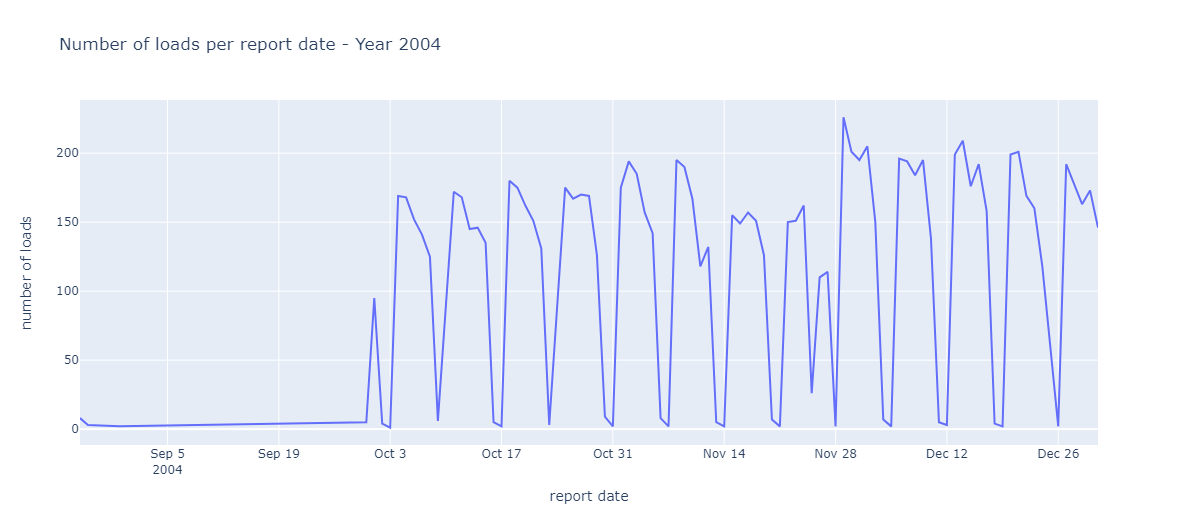

On the other hand, load time ranges from 2000-01-26 to 2030-11-24

In [ ]:
df_austin_waste.load_time.describe(datetime_is_numeric=True)

count                           740869
mean     2013-01-20 05:10:46.386069760
min                2000-01-26 12:39:00
25%                2008-07-24 12:27:00
50%                2013-01-04 12:45:00
75%                2017-06-02 10:30:00
max                2030-11-24 13:49:00
Name: load_time, dtype: object

Assuming that it is not yet possible to travel into the future (😅), there is some error in the load time timestamp.

In [ ]:
# Crosstab: Year VS Month available data
pd.crosstab(
    pd.DatetimeIndex(df_austin_waste['load_time']).year,
    pd.DatetimeIndex(df_austin_waste['load_time']).month
)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
row_0,,,,,,,,,,,,
2000,1,0,0,0,0,0,0,0,0,0,0,0
2001,0,0,2,0,0,0,0,0,0,2,0,0
2004,1,2,0,0,0,0,0,13,15,3247,3550,4126
2005,3838,3279,4185,4023,3784,3731,3460,4051,3814,3706,3835,4115
2006,4242,3508,4404,3889,4972,4064,3718,4155,3802,3814,3923,3990
2007,4083,3514,4393,4060,4074,3925,4106,4509,3766,4561,4252,4265
2008,4772,4252,4381,4514,4819,4347,4418,4017,4239,3900,3240,3693
2009,3825,3505,3707,3867,3350,3744,3657,3121,3385,3225,3208,3593
2010,3375,2957,3946,3863,3331,3306,3218,3288,3327,3245,3669,3744



With the same reasoning as before, the correct timestamps are likely to be in the range from August 2004 to July 2021.

In [ ]:
df_austin_waste = df_austin_waste.loc[
   (df_austin_waste['report_date'].between("2004/10/01", "2021/08/31")) &
   (df_austin_waste['load_time'].between("2004/10/01", "2021/08/31"))
].copy()

# Number of rows and columns
nrows, ncols = df_austin_waste.shape
print(f"Number of rows in the original data:\t{nrows_origin}")
print(f"Number of rows after preprocessing:\t{nrows}")
print(f"Total number of removed rows:\t{nrows_origin - nrows}")

Number of rows in the original data:	740873
Number of rows after preprocessing:	740828
Total number of removed rows:	45


We also expected the report date to always be posterior to the load timestamp. However, in more than 10 thousand rows, the report date precedes the load timestamp

In [ ]:
# Report date preceding the load timestamp
report_before_load = df_austin_waste.loc[
    (pd.DatetimeIndex(df_austin_waste['report_date']).date < 
     pd.DatetimeIndex(df_austin_waste['load_time']).date),
]

report_before_load

,report_date,load_type,load_time,load_weight,dropoff_site,route_type,route_number,load_id
39,2020-12-01,ORGANICS,2020-12-07 07:49:00,14480.0,ORGANICS BY GOSH,YARD TRIMMINGS-ORGANICS,OT10,899034
115,2020-11-24,RECYCLING - SINGLE STREAM,2020-11-25 07:15:00,13480.0,TDS - MRF,RECYCLING - SINGLE STREAM,RTAS43,899132
204,2020-12-08,GARBAGE COLLECTIONS,2020-12-09 14:15:00,17100.0,TDS LANDFILL,GARBAGE COLLECTION,PAT71,899253
212,2020-11-17,RECYCLING - SINGLE STREAM,2020-11-18 09:30:00,9920.0,TDS - MRF,RECYCLING - SINGLE STREAM,RTBU11,899130
316,2020-11-20,BULK,2020-11-23 07:51:00,420.0,TDS LANDFILL,BULK,BU10,899434
...,...,...,...,...,...,...,...,...
740868,2008-04-09,RECYCLING - PAPER,2021-07-11 07:00:39,1080.0,MRF,RECYCLING,RW05,273708
740869,2015-12-01,BULK,2021-07-11 07:05:29,9360.0,TDS LANDFILL,STORM,HAFLDBU15,676651
740870,2007-04-25,YARD TRIMMING,2021-07-11 07:01:56,NaN,HORNSBY BEND,YARD TRIMMINGS,YW04,224646
740871,2008-04-09,RECYCLING - COMINGLE,2021-07-11 07:00:39,3960.0,MRF,RECYCLING,RW04,273706


In [ ]:
# Number of rows with report date preceding load timestamp
print(f"Number of rows with report date preceding load timestamp: {report_before_load.shape[0]}")

# Percentage of rows with report date preceding load timestamp
print(f"Percentage of rows with report date preceding load timestamp: \
{report_before_load.shape[0] / df_austin_waste.shape[0] * 100:.2f}")

Number of rows with report date preceding load timestamp: 10130
Percentage of rows with report date preceding load timestamp: 1.37


In [ ]:
# Number of rows and columns
nrows, ncols = df_austin_waste.shape
print(f"Number of rows in the original data:\t{nrows_origin}")
print(f"Number of rows after preprocessing:\t{nrows}")
print(f"Total number of removed rows:\t{nrows_origin - nrows}")

Number of rows in the original data:	740873
Number of rows after preprocessing:	740828
Total number of removed rows:	45


###### Load IDs unique

The load ID should be unique for load, however we see several duplicates (50 rows)

In [ ]:
# Number of load ID dupliacates
df_austin_waste.loc[
    df_austin_waste.duplicated(subset=["load_id"], keep="first")
].shape[0]

50

Looking at the rows of the dataset it seems that the data has been inserted a second time, often adjusting the route_number

In [ ]:
df_austin_waste.loc[
    df_austin_waste.duplicated(subset=["load_id"], keep=False)
].sort_values("load_id").head(8)

,report_date,load_type,load_time,load_weight,dropoff_site,route_type,route_number,load_id
124122,2004-10-05,GARBAGE COLLECTIONS,2004-10-05 00:00:00,31520.0,TDS LANDFILL,GARBAGE COLLECTION,PT32,101305
485810,2004-10-05,GARBAGE COLLECTIONS,2004-10-05 00:00:00,31520.0,TDS LANDFILL,GARBAGE COLLECTION,PT33,101305
309020,2004-10-01,BULK,2004-10-05 11:58:00,6840.0,STEINER LANDFILL,BULK,BU26,101382
627710,2004-10-05,BULK,2004-10-05 11:58:00,6840.0,STEINER LANDFILL,BULK,BU06,101382
42942,2004-10-18,SWEEPING,2004-10-18 11:46:00,10760.0,STEINER LANDFILL,SWEEPER DUMPSITES,DSS02,102415
471441,2004-10-18,SWEEPING,2004-10-18 11:46:00,10760.0,STEINER LANDFILL,SWEEPER DUMPSITES,DSS04,102415
740816,2004-10-14,GARBAGE COLLECTIONS,2021-07-11 07:03:11,NaN,TDS LANDFILL,GARBAGE COLLECTION,PH10,103691
740725,2004-10-21,GARBAGE COLLECTIONS,2021-07-11 07:03:09,NaN,TDS LANDFILL,GARBAGE COLLECTION,PH10,103691


In 49 out of the 50 lines which duplicated load_time, the route_number is changed.

In [ ]:
# Number of rows with same "load_id", "load_type", "load_time", "load_weight",
# "dropoff_site", "route_type" and different "route_number" and/or "report_date"
df_austin_waste.loc[
    df_austin_waste.duplicated(
        subset=["load_id", "load_type", "load_time", "load_weight",
                "dropoff_site", "route_type"],
        keep="first"
    )
].shape[0]

49

In the remaining case, the load_time is changed

In [ ]:
# Number of rows with same "load_id", "load_type", "load_weight",
# "dropoff_site", "route_type" and different "route_number" and/or "report_date"
df_austin_waste.loc[
    df_austin_waste.duplicated(
        subset=["load_id", "load_type", "load_weight",
                "dropoff_site", "route_type"],
        keep="first"
    )
].shape[0]

50

Assuming that these cases are duplicates due to corrections, we decide to keep only the last of the rows sharing the same "load_id".

In [ ]:
df_austin_waste = df_austin_waste.sort_values("report_date").drop_duplicates(
    subset=["load_id"], keep='last')

In [ ]:
# Number of rows and columns
nrows, ncols = df_austin_waste.shape
print(f"Number of rows in the original data:\t{nrows_origin}")
print(f"Number of rows after preprocessing:\t{nrows}")
print(f"Total number of removed rows:\t{nrows_origin - nrows}")

Number of rows in the original data:	740873
Number of rows after preprocessing:	740778
Total number of removed rows:	95


### OpenStreeMap Data

Let's now investigate Austing urban topology by analysing its available map as OpenStreeMap file

#### Extract Austin OpenStreetMap nodes

Define two had hoc handler classes to extract nodes from Austin OSM file. For each map node, geographical coordinates are available. They will be essential to match map nodes to the corresponding waste collection route. In addition OSM nodes could have different tags, reporting the type of urban structure of its function (please refere to the documentation for more details). Here the following node tags are considered:
* amenity
* tourism
* healthcare
* leisure
* historic
* office
* shop

In [ ]:
# the following code cells are commented since they require quite long execution time; 

'''
class ExtractTagType2(osmium.SimpleHandler):
    def __init__(self, tag_type1):
        super(ExtractTagType2, self).__init__()
        self.tag_interest_places = []
        self.tag_type1 = tag_type1
        self.tags_type2 = []

    def node(self, n):
        self.tags_type2.append(n.tags.get(self.tag_type1))

class CustomHandler(osmium.SimpleHandler):
    def __init__(self, node_type1, node_type2):
        super(CustomHandler, self).__init__()
        self.interest_places = []
        self.node_type1 = node_type1
        self.node_type2 = node_type2

    def node(self, n):  # agisce sui nodi
        if n.tags.get(self.node_type1) == self.node_type2 and 'name' in n.tags: # o.tags.get('tourism') == 'hotel' and 'name' in o.tags:
            self.interest_places.append((n.id, self.node_type1, self.node_type2, n.location.lat, n.location.lon, n.tags['name'], n.timestamp))

'''

In [ ]:
'''
src_filepath = dataPath + "/Austin.osm.pbf" 
tags_type1 = ['amenity','tourism','healthcare','leisure','historic','office','shop']


# create dictionary tag.k : tag.v given tags_type1
tags_type2 = {}

for t in tags_type1:
    print('searching '+t)
    h = ExtractTagType2(t)
    h.apply_file(src_filepath)
    tags_type2[t] = set(h.tags_type2)
'''

In [ ]:
'''
nodes = []

for k in tags_type2.keys():
    i = 1
    l = len(tags_type2[k])
    for t in tags_type2[k]:

      print(k,i,'out of',l)  
      h = CustomHandler(k, t)
      h.apply_file(src_filepath)
      nodes += h.interest_places

      i+=1
'''   

In [ ]:
'''
# create DataFrame 
df = pd.DataFrame(nodes, columns =["ID", "tag_type1", "tag_type2", "latitude", "longitude", "name", "timestamp"])

# better encoding
new_rows = []
for i in df.ID.unique():
    sub = df.loc[df.ID == i]
    tag_type1_encoding = [0]*7
    tags_type2 = [np.nan]*7
    for j in range(sub.shape[0]):

        tag_type2 = sub.iloc[j,:].tag_type2

        if tag_type2:
            tag_type1 = sub.iloc[j,:].tag_type1

            tag_type1_encoding[tags_type1.index(tag_type1)] = 1
            tags_type2[tags_type1.index(tag_type1)] = tag_type2

    new_rows.append(tuple([sub.iloc[j,:].ID] + tag_type1_encoding + tags_type2 + [sub.iloc[j,:].latitude, sub.iloc[j,:].longitude, sub.name.values[0], sub.iloc[j,:].timestamp]))

# create new DataFrame 
map_extraction = pd.DataFrame(new_rows, columns =["ID", 'amenity','tourism','healthcare','leisure','historic','office','shop', 'amenity_type','tourism_type','healthcare_type','leisure_type','historic_type','office_type','shop_type', "latitude", "longitude", "name", "timestamp"])

# export
# map_extraction.to_csv(dataPath+'/map_extraction.csv', header=True, index=False)
'''

#### Assign map nodes to waste routes

Now, the available OSM Austin nodes should be matched to the corresponding waste collection area. In practice, the ```shapely``` library is exploited to solve this task as a geometric problem: given each node $n$ as a $2D$ point with coordinates $(longitude, latitude)$ check if it belongs to a collection route $R$ described as a multipolygon with geographical coordinates as verteces.

In [ ]:
waste_routes = pd.read_excel(dataPath+"/BOUNDARIES_garbage_collection_routes_data.xlsx")
map_extraction = pd.read_csv(dataPath + '/map_extraction.csv')

# inspect multipoligon
es = waste_routes.the_geom.values[0]

In [ ]:
# convert from string to shapely.MultiPolygon object

col_poly = []
for i in range(waste_routes.shape[0]):
    col_poly.append(shapely.wkt.loads(waste_routes.iloc[i].the_geom))
    
waste_routes['MultiPolygons'] = col_poly

In [ ]:
'''
# check which road the nodes belong to
node_routes = []

for i in range(map_extraction.shape[0]):
    routes = []
    point = Point(map_extraction.iloc[i].longitude, map_extraction.iloc[i].latitude)
    for j in range(waste_routes.shape[0]):
        multipolygon = waste_routes.iloc[j].MultiPolygons
        if multipolygon.contains(point):
            routes.append(waste_routes.iloc[j].ROUTE_NAME)
    node_routes.append(routes)
'''

In [ ]:
'''
# better encode matched routes as str or np.nan 
node_routes_mod = []
for i in node_routes:
    if len(i):
        node_routes_mod.append(i[0])
    else:
        node_routes_mod.append(np.nan)

map_extraction['Routes'] = node_routes_mod

# map_extraction.to_csv(dataPath + '/map_extraction_with_routes.csv')
'''

In [ ]:
map_extraction = pd.read_csv(dataPath + '/map_extraction_with_routes.csv').drop('Unnamed: 0', axis=1)

#### Compute collection route summary statistics

In [ ]:
routes = []
amenity = []
tourism = []
healthcare = []
leisure = []
historic = []
office = []
shop = []
tot = []

for r in map_extraction.Routes.unique():
    routes.append(r)
    amenity.append(np.sum( (map_extraction.Routes == r) & (map_extraction.amenity == 1)))
    tourism.append(np.sum( (map_extraction.Routes == r) & (map_extraction.tourism == 1)))
    healthcare.append(np.sum( (map_extraction.Routes == r) & (map_extraction.healthcare == 1)))
    leisure.append(np.sum( (map_extraction.Routes == r) & (map_extraction.leisure == 1)))
    historic.append(np.sum( (map_extraction.Routes == r) & (map_extraction.historic == 1)))
    office.append(np.sum( (map_extraction.Routes == r) & (map_extraction.office == 1)))
    shop.append(np.sum( (map_extraction.Routes == r) & (map_extraction.shop == 1)))
    tot.append(np.sum( (map_extraction.Routes == r)))

route_stats = pd.DataFrame(routes, columns = ['Route'])
route_stats['Amenity_nodes'] = amenity 
route_stats['Tourism_nodes'] = tourism 
route_stats['Healthcare_nodes'] = healthcare 
route_stats['Leisure_nodes'] = leisure
route_stats['Historic_nodes'] = historic 
route_stats['Office_nodes'] = office
route_stats['Shop_nodes'] = shop 
route_stats['All_labeled_nodes'] = np.array(amenity) + np.array(tourism) + np.array(healthcare) + np.array(leisure) + np.array(historic) + np.array(office) + np.array(shop)
route_stats['All_nodes'] = tot

route_stats = route_stats.dropna()



In [ ]:
# extract only mapped routes

waste_sub = df_austin_waste.loc[df_austin_waste["route_number"].isin(route_stats.Route.values)]


In [ ]:
# inspect collection types

waste_sub['load_type'].value_counts()

GARBAGE COLLECTIONS            160491
RECYCLING - SINGLE STREAM          15
TIRES                               9
YARD TRIMMING                       2
SWEEPING                            2
MIXED LITTER                        1
BAGGED LITTER                       1
YARD TRIMMING - X-MAS TREES         1
CONTAMINATED ORGANICS               1
Name: load_type, dtype: int64

In [ ]:
# just consider GARBAGE COLLECTIONS load type

waste_sub = waste_sub.loc[waste_sub['load_type'] == 'GARBAGE COLLECTIONS']

In [ ]:
# summarizing dataset

load_means = []
load_maxs = []
load_mins = []

route_mean_collection_int = []
route_min_collection_int = []
route_max_collection_int = []


for r in route_stats['Route'].values:
    subset = waste_sub.loc[waste_sub['route_number'] == r]    
    subset.sort_values(by = ['load_time'], inplace = True)
    times = subset['load_time'].values
    loads = subset['load_weight'].values
    
    # load
    if len(loads):
        load_means.append(np.nanmean(loads))
        load_maxs.append(np.nanmax(loads))
        load_mins.append(np.nanmin(loads))
    else:
        load_means.append(np.nan)
        load_maxs.append(np.nan)
        load_mins.append(np.nan)
    
    # period
    diff = []
    for i in range(len(times)-1):
        collection_time1 = times[i]
        collection_time2 = times[i+1]

        diff.append((collection_time2 - collection_time1)/ np.timedelta64(1, 'h')) # difference in hour

    route_mean_collection_int.append(np.nanmean(diff))
    try:
        route_min_collection_int.append(np.nanmax(diff)) 
    except: 
        route_min_collection_int.append(np.nan)
    try: 
        route_max_collection_int.append(np.nanmin(diff)) 
    except: route_max_collection_int.append(np.nan)
    
    
route_stats['Mean Load'] = load_means
route_stats['Max Load'] = load_maxs
route_stats['Min Load'] = load_mins 

route_stats['Mean collection period (h)'] = route_mean_collection_int
route_stats['Max collection period (h)'] = route_max_collection_int
route_stats['Min collection period (h)'] = route_min_collection_int


### EDA

In [ ]:
# Number of unique values per field
fields = ["load_type", "dropoff_site", "route_type", "route_number", "load_id"]

print(f"Field\t\tN. of unique values")
for field in fields:
    print(f"{field:<15}\t{df_austin_waste[field].nunique()}")

Field		N. of unique values
load_type      	22
dropoff_site   	34
route_type     	41
route_number   	2221
load_id        	740778


#### Load type

There are 22 different specific types of waste collection

In [ ]:
# Loads per load type
print(f"Number of unique load_type values:\t \
{df_austin_waste['load_type'].nunique()}")

Number of unique load_type values:	 22


##### Number of loads per load type

The first 2 types by number of loads are:

* garbage collection (34.9%)
* recycling - single stream (19.9%)

which together account for more than 50% of the loads in the dataset.

Next is the sweeping type, for which we know, however, that more than 80% of the weight data are Nan

In [ ]:
# Pie chart - Number of loads per load type
df_load_type = df_austin_waste.groupby('load_type').size().to_frame('n_loads'
).sort_values(by='n_loads', ascending=False)
load_types = df_load_type.index

fig = px.pie(df_load_type, values='n_loads', names=df_load_type.index,
             labels={"load_type": "load type", "n_loads": "number of loads"},
             title="Loads per load type")
fig.show()

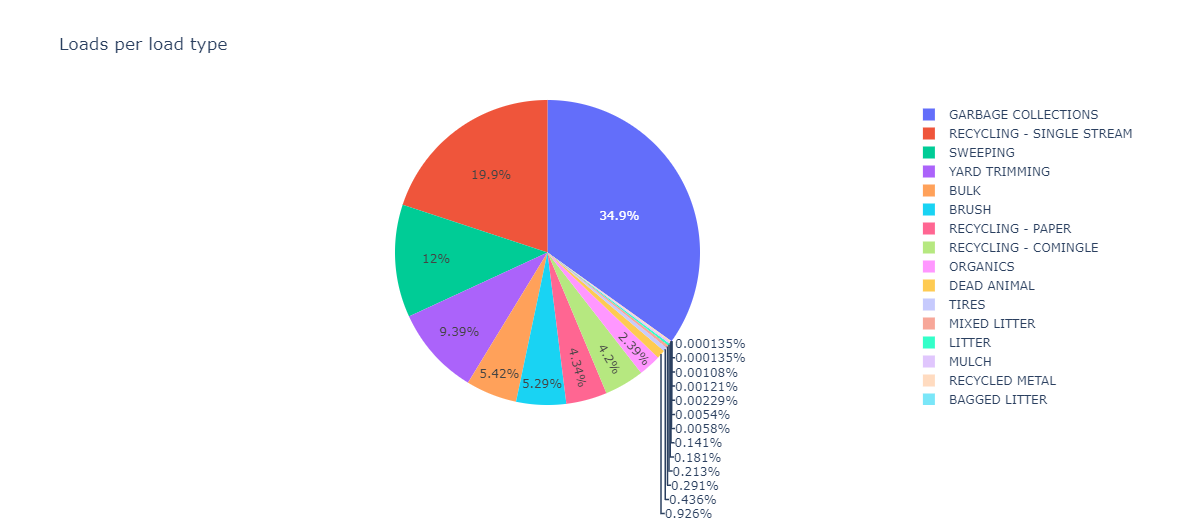

##### Time span per load type

The absolute number of loads, however, may be higher or lower depending on when the type of collection was launched or terminated. For example, we note that organic type collection only began in 2018. Mulch, on the other hand, has its last collection in 2017.

In [ ]:
# Number of loads and time span per load type
df_austin_waste.groupby('load_type').agg(
    n_loads = ('load_id', 'count'),
    first_load_time = ('load_time', 'min'),
    last_load_time = ('load_time', 'max')
).sort_values("n_loads", ascending=False)

,n_loads,first_load_time,last_load_time
load_type,,,
GARBAGE COLLECTIONS,258398,2004-10-01 10:39:00,2021-07-11 07:07:42
RECYCLING - SINGLE STREAM,147645,2004-10-18 13:25:00,2021-07-11 07:05:51
SWEEPING,88560,2004-10-01 05:45:00,2021-07-11 07:06:12
YARD TRIMMING,69557,2004-10-01 00:00:00,2021-07-11 07:06:46
BULK,40114,2004-10-01 11:02:00,2021-07-11 07:07:01
BRUSH,39164,2004-10-04 00:00:00,2021-07-11 07:02:49
RECYCLING - PAPER,32160,2004-10-01 10:13:00,2021-07-11 07:02:56
RECYCLING - COMINGLE,31122,2004-10-01 10:19:00,2021-07-11 07:01:08
ORGANICS,17719,2018-05-02 11:40:00,2021-07-09 15:36:00


In addition, even if the collection of a certain type covers the entire time span from 2004 to 2021, the number of loads for that type can change significantly. For example, the "recycling -single stream" collection type experiences a significant increase in the number of loads since about October 2008 (see the plot below)

In [ ]:
# Time series dataframe
ts_austin_waste = df_austin_waste.sort_values('load_time')
ts_austin_waste.index = ts_austin_waste['load_time']
ts_austin_waste.drop('load_time', axis=1, inplace=True)

In [ ]:
# Choose load types
selected_types = load_types[0:3]

# Choose resample
resample_freq = '7D' # D, M, Y

fig = px.line(
    ts_austin_waste.loc[ts_austin_waste['load_type'].isin(selected_types)
    ].groupby('load_type').resample(resample_freq)['load_id'
    ].count().reset_index(),
    x='load_time', y="load_id", color='load_type',
    labels={"load_time": "load time", "load_id": "n. loads",
            "load_type": "load type"},
    title=f"Number of loads (dataframe rows) per load type"
)

fig.show()

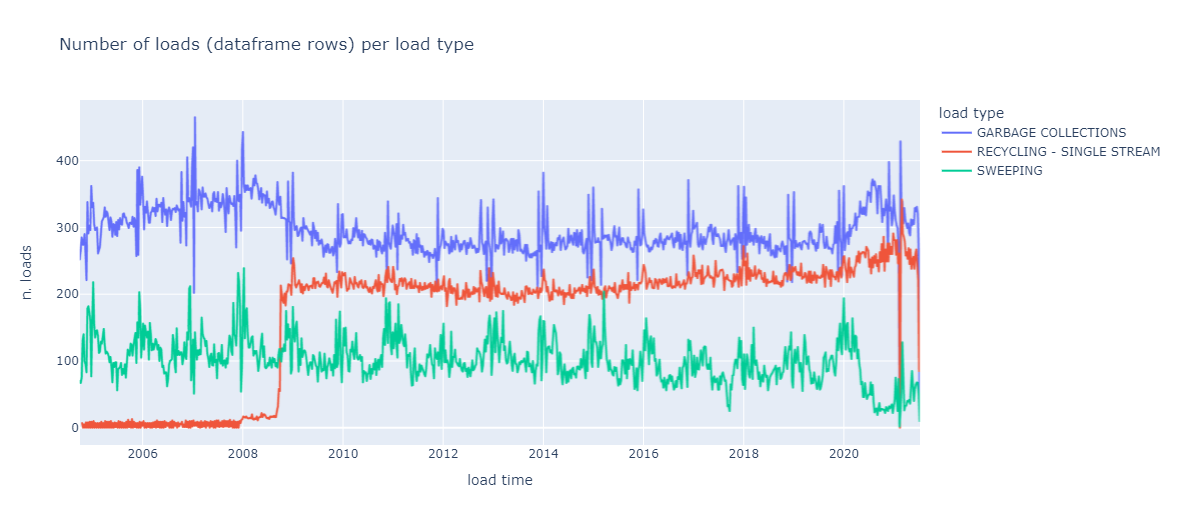

##### Load weight per load type

In [ ]:
df_austin_waste.groupby("load_type").load_weight.describe().sort_values(
    "count", ascending=False)

,count,mean,std,min,25%,50%,75%,max
load_type,,,,,,,,
GARBAGE COLLECTIONS,258361.0,17083.149320,7733.530517,0.0,12020.0,17780.0,22380.0,1562821.0
RECYCLING - SINGLE STREAM,147605.0,9896.349798,4257.932005,0.0,6580.0,10740.0,12760.0,324434.0
YARD TRIMMING,69540.0,11352.155076,5440.878714,0.0,7400.0,11440.0,15480.0,403243.0
BULK,40111.0,7497.147840,4051.254988,0.0,4680.0,6920.0,10280.0,407022.0
BRUSH,39141.0,6000.935004,2457.418852,0.0,4260.0,5500.0,7240.0,109880.0
RECYCLING - PAPER,32153.0,4405.501819,2430.213010,0.0,2480.0,4180.0,6020.0,15000.0
RECYCLING - COMINGLE,31113.0,3262.406679,1546.679519,0.0,2200.0,3320.0,4260.0,30760.0
ORGANICS,17703.0,10873.430831,4829.316500,0.0,7460.0,10600.0,14200.0,29660.0
SWEEPING,16520.0,11538.712893,6341.304486,0.0,7740.0,10700.0,14520.0,401514.0


In [ ]:
# Choose load types
selected_types = load_types

fig = px.box(
    df_austin_waste.loc[df_austin_waste['load_type'].isin(selected_types)
    ],
    x='load_type', y="load_weight",
    labels={"load_type": "load type", "load_weight": "load weight"},
    title=f"Load weights per load type"
)
fig.update_layout(yaxis_range=[0,100*10**3])
fig.show()

In [ ]:
# Choose load types
selected_types = load_types[0:3] # ["RECYCLING - PAPER"] 

# Choose resample
resample_freq = '7D' # D, M, Y

fig = px.line(
    ts_austin_waste.loc[ts_austin_waste['load_type'].isin(selected_types)
    ].groupby('load_type').resample(resample_freq)['load_weight'
    ].sum().reset_index(),
    x='load_time', y="load_weight", color='load_type',
    labels={"load_time": "load time", "load_weight": "load weight",
            "load_type": "load type"},
    title=f"Load weight sum per load type - Time aggregation {resample_freq}"
)

fig.show()

##### Route type/number and dropoff site per load type

In general we see that a type of collection can be associated with multiple dropoff sites, route numbers and route types

In [ ]:
df_austin_waste.groupby(["load_type"]).agg(
    unique_dropoff_site=("dropoff_site", "nunique"),
    unique_route_type=("route_type", "nunique"),
    unique_route_number=("route_number", "nunique")
)

,unique_dropoff_site,unique_route_type,unique_route_number
load_type,,,
BAGGED LITTER,3,7,20
BRUSH,13,20,120
BULK,10,19,93
CONTAMINATED ORGANICS,1,1,1
CONTAMINATED RECYCLING,3,1,6
CONTAMINATED YARD TRIMMINGS,1,1,1
DEAD ANIMAL,8,5,13
GARBAGE COLLECTIONS,14,12,472
LITTER,11,14,143


#### Dropoff sites

In [ ]:
# Loads per load type
load_type_group = df_austin_waste.groupby(field)
print(f"Number of unique load_type values:\t{df_austin_waste['load_type'].nunique()}")

Number of unique load_type values:	22


The dropoff sites are the location where each type of waste is delivered for disposal, recycling or reuse.

* TDS Landfill indicates the Texas Disposal System landfill located at 12200 Carl Rd, Creedmoor, TX 78610;
* Balcones Recycling is a recycling facility located at 9301 Johnny Morris Road Austin, TX 78724;
* MRF is a Materials Recycling Facility (such as Texas Disposal Systems or Balcones Recycling);
* Hornsby Bend is located at 2210 FM 973, Austin, TX 78725 and accepts food scraps, yard trimmings, food-soiled paper and other materials collected by ARR, and combined with other waste to produce nutrient-rich dillo dirt, used for landscaping. ([source](https://data.austintexas.gov/Utilities-and-City-Services/Waste-Collection-Diversion-Report-daily-/mbnu-4wq9))

###### Loads per dropoff site

In [ ]:
# Loads per dropoff site
df_dropoff_site_counts = df_austin_waste.groupby('dropoff_site').size(
).to_frame('loads').sort_values(by='loads', ascending=False)

df_dropoff_site_percentage = df_dropoff_site_counts.div(
    df_dropoff_site_counts.loads.sum()/100)

fig = px.bar(df_dropoff_site_percentage.reset_index(),
             x='dropoff_site', y='loads',
            labels={"dropoff_site": "dropoff site", "loads": "percentage of loads"},
            title="Loads per dropoff site")
fig.show()

In [ ]:
# Load type per dropoff site
df_dropoff_site_load_type_count = df_austin_waste.groupby(['dropoff_site', 'load_type']
).size().to_frame('loads').sort_values(by='loads', ascending=False)

# Percentage of load types per dropoff site
df_dropoff_site_load_type_percentage = df_dropoff_site_load_type_count.div(
    df_dropoff_site_load_type_count.groupby('dropoff_site')[['loads']
    ].transform('sum') / 100)

fig = px.bar(df_dropoff_site_load_type_percentage.reset_index(),
        x='dropoff_site', y='loads', color="load_type",
        labels={"dropoff_site": "dropoff site", "loads": "percentage of loads"},
        title="Loads per dropoff site")
fig.show()

#### OSM nodes and mean load

Inspect if the number of matched OSM nodes per route influence its average load

In [ ]:
fig = px.scatter(route_stats, x = 'All_labeled_nodes', y = 'Mean Load')
fig.update_xaxes(range=[0, 100])
fig.show()

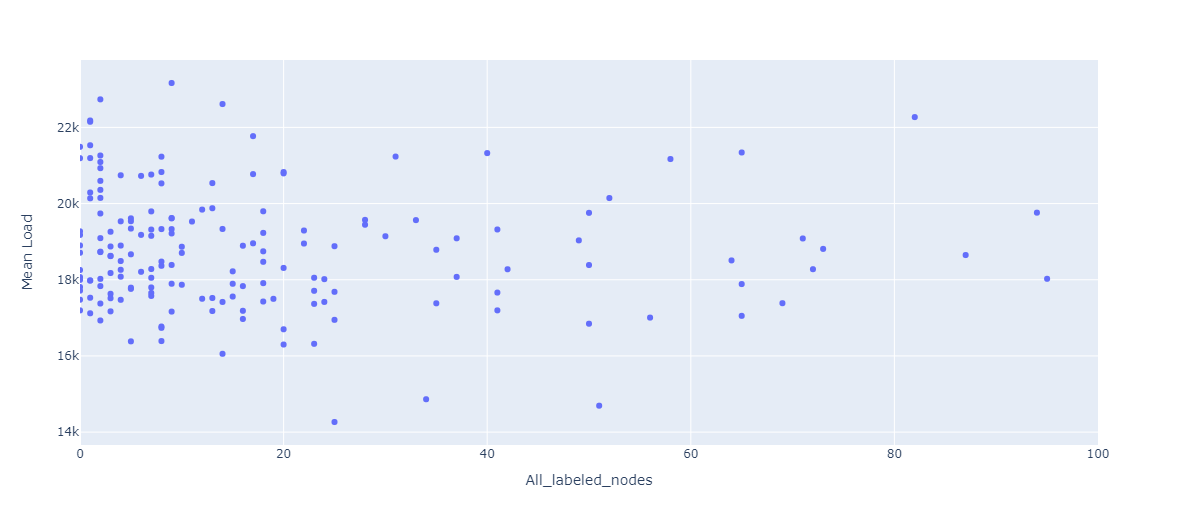

In [ ]:
fig = px.scatter(route_stats, x = 'Amenity_nodes', y = 'Mean Load')
fig.update_xaxes(range=[0, 100])
fig.show()

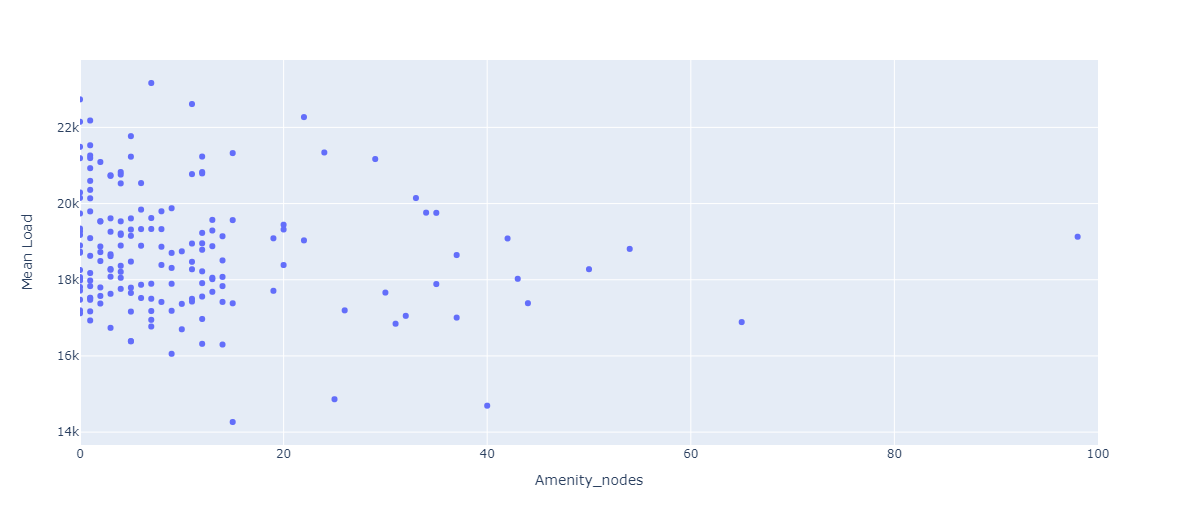

#### Mean collection period and mean load

Inspect any relation between number of OSM nodes, average collection frequency and weight

In [ ]:
fig = px.bar(route_stats, x='Route', y='Mean Load')
fig.add_hline(y=np.nanmean(waste_sub['load_weight'].values), line_width=2, line_dash="dash", line_color="red")
fig.show()

In [ ]:
fig = px.scatter(route_stats, x = 'Mean collection period (h)', y = 'Mean Load',
                size= 'Amenity_nodes',
                color = 'Route')

fig.show()

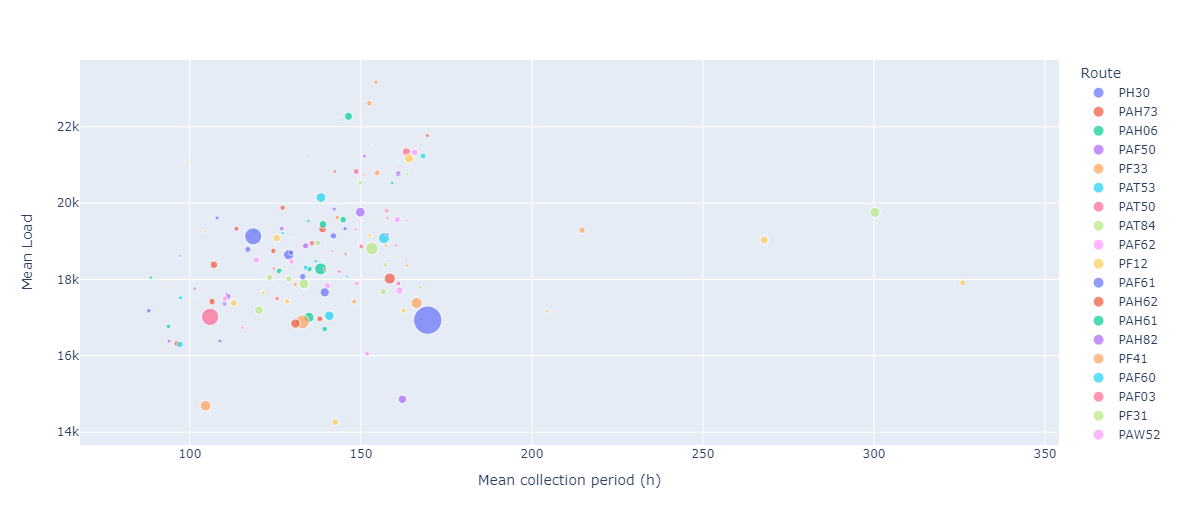

### Meteo Stat Data

In [ ]:
stations = ms.Stations()
stations = stations.region('US', 'TX')
print('Stations in Austin TX:', stations.count())

# Set time period
start = datetime(2004, 10, 1)
end = datetime(2021, 7, 31)

# Create Point for Austin, TX
austin_tx = ms.Point(30.2672, -97.7431)

# Get daily data
data = ms.Daily(austin_tx, start, end)
data = data.fetch()

In [ ]:
# Choose load types
selected_variable = ["prcp"]
# Choose resample
resample_freq = 'D' # D, M, Y


fig = px.line(
    data.loc[(data.index > "2018") & (data.index < "2020")].resample(resample_freq)[selected_variable
    ].mean().reset_index(),
    x='time', y=selected_variable
)

fig.show()

Investiganting correlation between waste load and weather conditions

In [ ]:
selected_load_type = "ORGANICS"

weathers_vs_weight = pd.merge(
    data.reset_index(),
    ts_austin_waste.loc[ts_austin_waste.load_type==selected_load_type].resample('D').load_weight.sum().reset_index(),
    left_on="time", right_on="load_time"
).drop('load_time', axis=1)

weathers_vs_weight.loc[weathers_vs_weight.load_weight>0,].corr()[['load_weight']]

### ARIMA

In [ ]:
collectionType = 'GARBAGE COLLECTIONS'
dfM = df_austin_waste[df_austin_waste.load_type == collectionType].set_index('load_time').sort_index()
dfM.head()

,report_date,load_type,load_weight,dropoff_site,route_type,route_number,load_id
load_time,,,,,,,
2004-10-01 10:39:00,2004-10-01,GARBAGE COLLECTIONS,6320.0,TDS LANDFILL,GARBAGE COLLECTION,PAF77,101566
2004-10-01 10:42:00,2004-10-01,GARBAGE COLLECTIONS,18600.0,TDS LANDFILL,GARBAGE COLLECTION,PAF72,101537
2004-10-01 10:43:00,2004-10-01,GARBAGE COLLECTIONS,5400.0,TDS LANDFILL,GARBAGE COLLECTION,PAF79,101593
2004-10-01 10:50:00,2004-10-01,GARBAGE COLLECTIONS,10500.0,TDS LANDFILL,GARBAGE COLLECTION,PAF03,102623
2004-10-01 11:46:00,2004-10-01,GARBAGE COLLECTIONS,19720.0,TDS LANDFILL,GARBAGE COLLECTION,PF33,101657


In [ ]:
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2004-10-01,26.7,20.6,32.2,0.0,0.0,NaN,7.6,NaN,1013.7,0.0
2004-10-02,22.2,18.3,26.1,50.3,0.0,NaN,9.0,NaN,1020.3,0.0
2004-10-03,25.6,18.9,31.7,0.0,0.0,NaN,3.6,NaN,1021.5,0.0
2004-10-04,25.0,18.9,31.1,4.3,0.0,NaN,4.7,NaN,1019.4,0.0
2004-10-05,22.2,17.8,26.7,0.0,0.0,NaN,6.8,NaN,1020.6,0.0


In [ ]:
yM = dfM.load_weight.resample('D').sum()
yM = yM[(yM.index.weekday != 5) & (yM.index.weekday != 6)]

In [ ]:
# 80% train, 20% test
yTrain, yTest = yM[:int(0.7*yM.shape[0])], yM[int(0.3*yM.shape[0]):]

In [ ]:
yScaler = MinMaxScaler(feature_range=(-1,1))

In [ ]:
yTr = yScaler.fit_transform(np.array(yTrain).reshape([-1,1]))
yT = yScaler.transform(np.array(yTest).reshape([-1,1]))

In [ ]:
adfTest = pmdarima.arima.ADFTest(alpha=0.05)
print(adfTest.should_diff(yTr))

(0.01, False)


In [ ]:
aa = pmdarima.auto_arima(yTr) # m=periodicity

In [ ]:
nSteps = 22 # roughly one month
fc = aa.predict(nSteps)

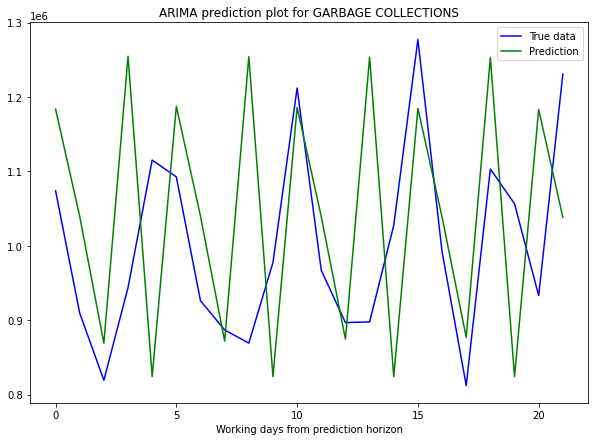

In [ ]:
f = plt.figure(figsize=(10,7))
x = np.arange(nSteps)
plt.plot(x, yScaler.inverse_transform(yT)[:nSteps], c='blue', label='True data')
plt.plot(x, yScaler.inverse_transform(fc.reshape(-1, 1))[:nSteps], c='green', label='Prediction')
plt.xlabel('Working days from prediction horizon')
plt.legend()
plt.title('ARIMA prediction plot for ' + collectionType)
plt.show()

In [ ]:
aa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3063
Model:               SARIMAX(5, 1, 5)   Log Likelihood                2167.933
Date:                Wed, 23 Mar 2022   AIC                          -4313.865
Time:                        21:15:18   BIC                          -4247.570
Sample:                             0   HQIC                         -4290.044
                               - 3063                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8914      0.018    -48.735      0.000      -0.927      -0.856
ar.L2         -0.8649      0.021    -41.745      0.000      -0.905      -0.824
ar.L3         -0.8442      0.018    -46.019      0.000      -0.880      -0.808
ar.L4         -0.8544      0.015    -58.141      0.000      -0.883      -0.826
ar.L5          0.1134      0.015      7.744      0.000       0.085       0.142
ma.L1          0.0442      0.015      2.869      0.004       0.014       0.074
ma.L2         -0.0174      0.013     -1.310      0.190      -0.043       0.009
ma.L3         -0.0233      0.013     -1.816      0.069      -0.048       0.002
ma.L4          0.0092      0.016      0.589      0.556      -0.021       0.040
ma.L5         -0.8218      0.011    -75.051      0.000      -0.843      -0.800
sigma2         0.0142      0.000    122.757      0.000       0.014       0.014
===================================================================================
Ljung-Box (L1) (Q):                   3.01   Jarque-Bera (JB):             68471.68
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -2.33
Prob(H) (two-sided):                  0.14   Kurtosis:                        25.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
f = plt.figure()
aa.plot_diagnostics()
plt.show()

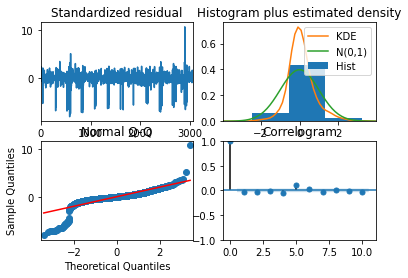

In [ ]:
lags = 22
f = plt.figure(figsize=(10,7))
pmdarima.utils.plot_acf(aa.resid(), lags=lags, alpha=0.05, zero=False)
plt.show()

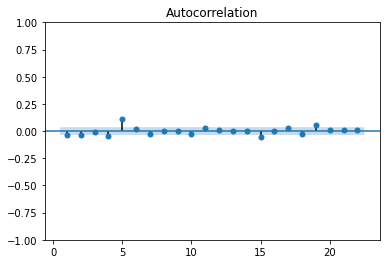

In [ ]:
f = plt.figure()
pmdarima.utils.plot_pacf(aa.resid(), lags=np.floor(lags/2-1), # (lags-1)/2 could be fine as well (and plot one lag more if lags is even)
                             alpha=0.05, zero=False)
plt.show()

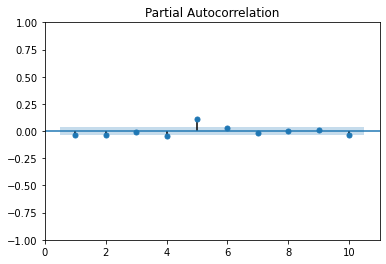

In [ ]:
dataM = data.loc[yM.index,:].fillna(0)

Let's add the daily average temperature and precipitations to improve the model.

In [ ]:
yScalerExog = MinMaxScaler(feature_range=(-1,1))
yTrExog = yScalerExog.fit_transform(np.array(dataM.iloc[:int(0.7*yM.shape[0]),[0,3]]))

In [ ]:
aaExog = statsmodels.tsa.arima.model.ARIMA(yTr, exog=yTrExog, order=(5, 1, 5), enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False, trend_offset=1, dates=None, freq=None, missing='none', validate_specification=False)

In [ ]:
aaExogF = aaExog.fit()

In [ ]:
fig, ax = plt.subplots()
ax = yScaler.transform(yM).plot(ax=ax)
fig = aaExogF.plot_predict(yM.index[0], yM.index[int(0.3*yM.shape[0])], dynamic=True, ax=ax, plot_insample=False)
plt.show()

## 🖼️ Visualisations


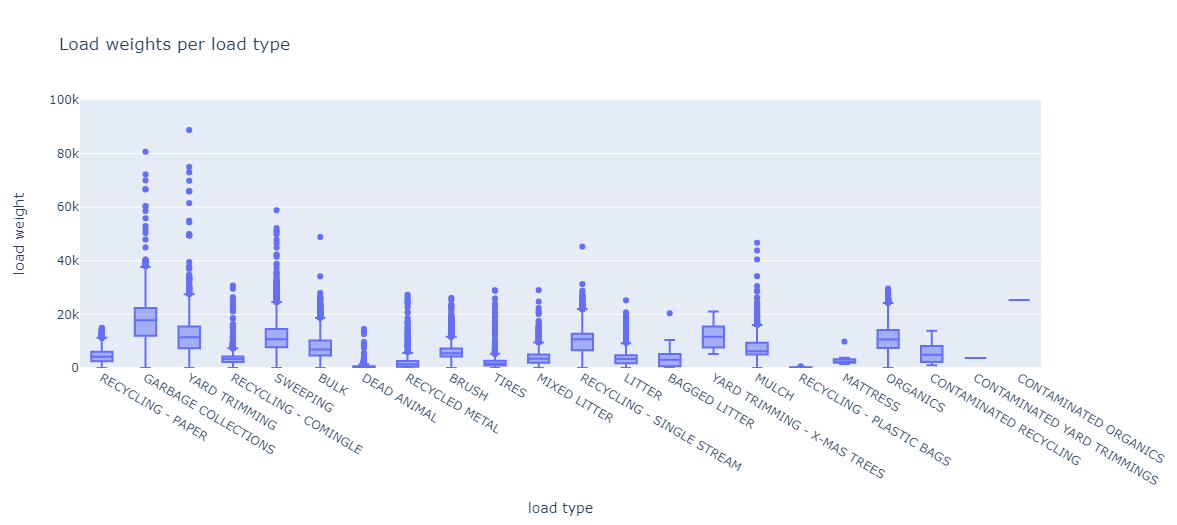

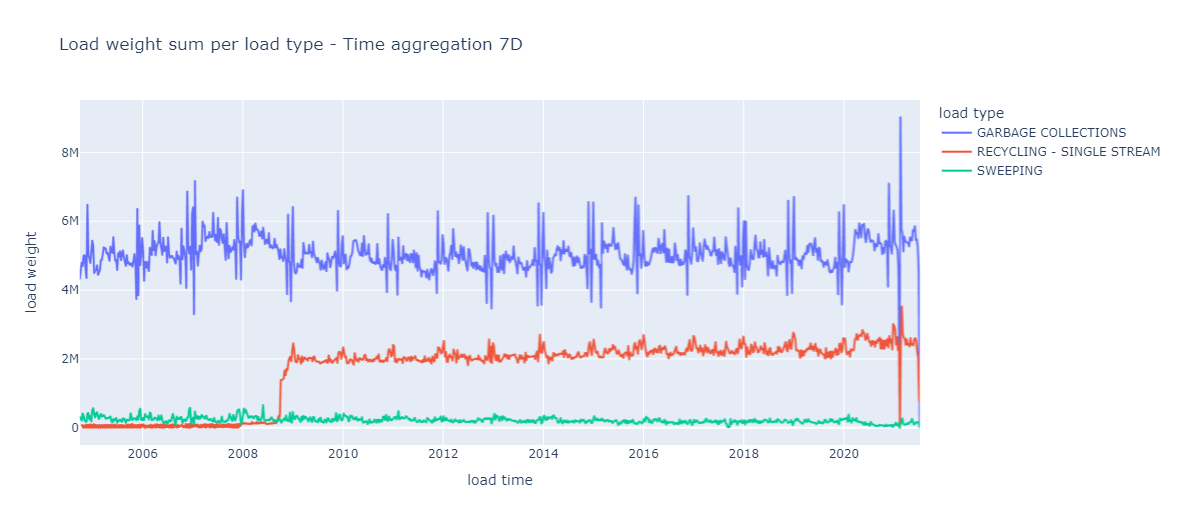

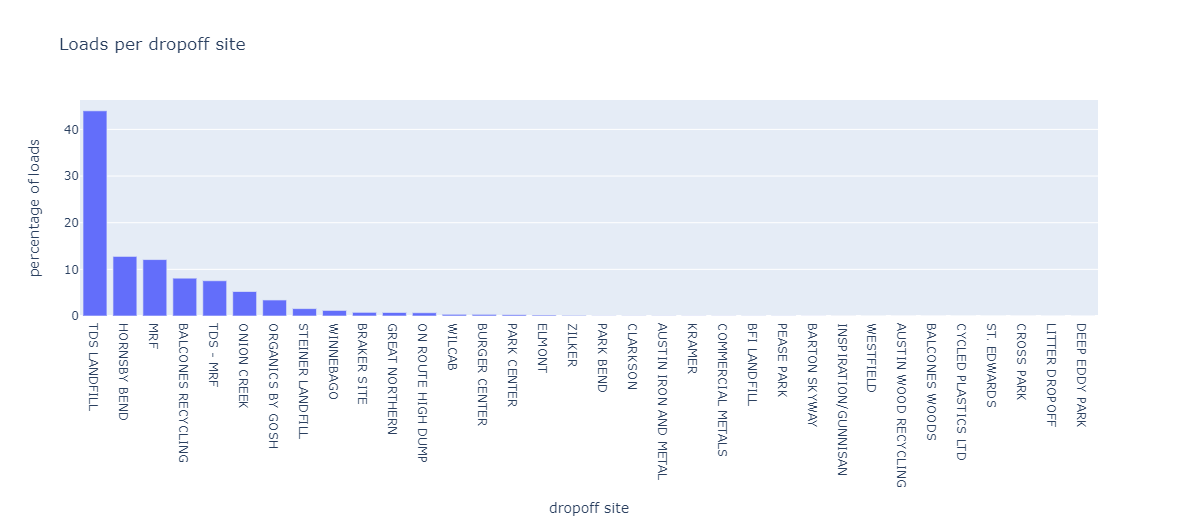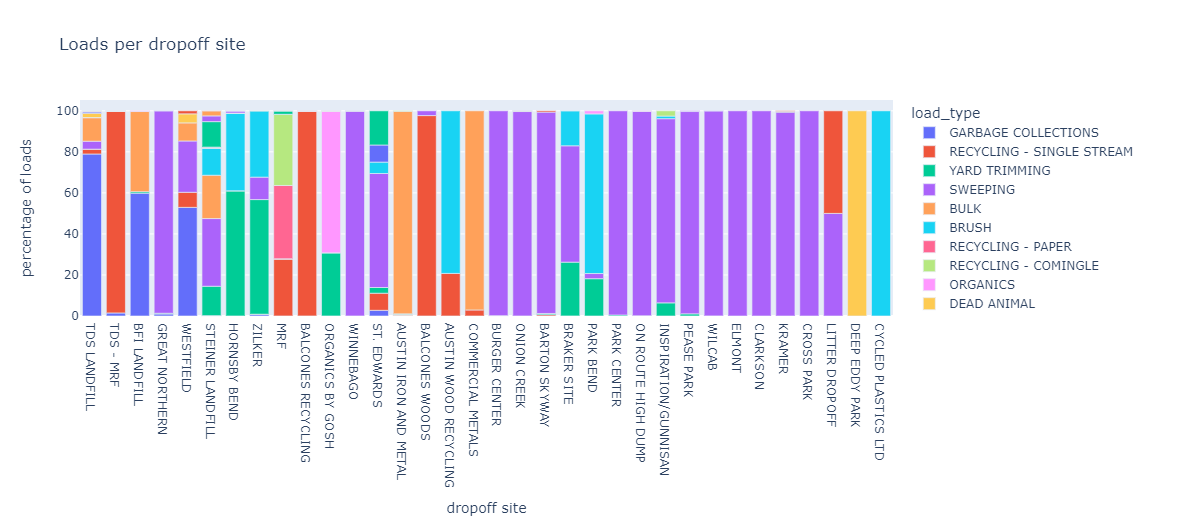

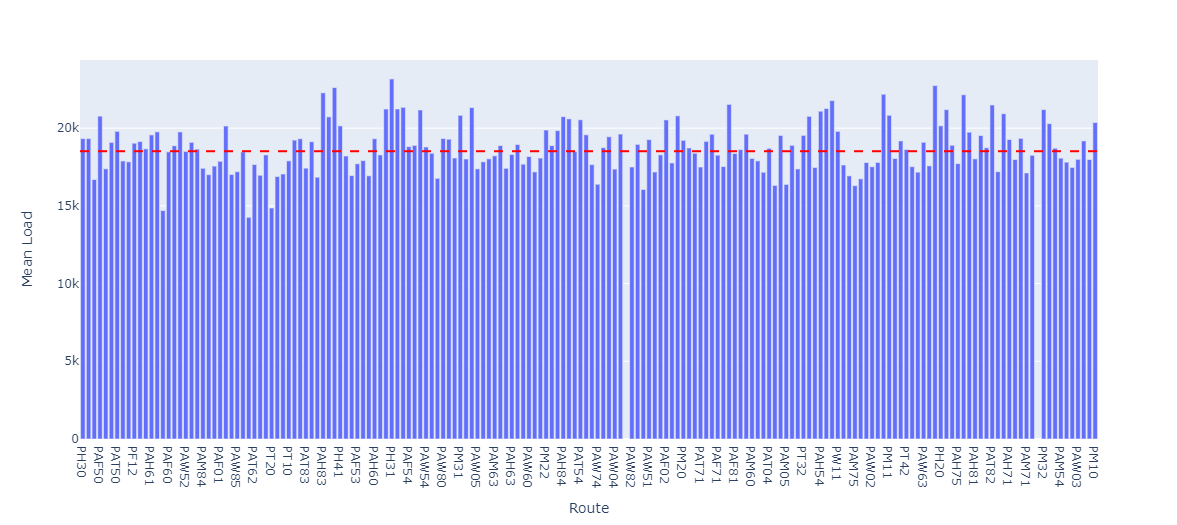

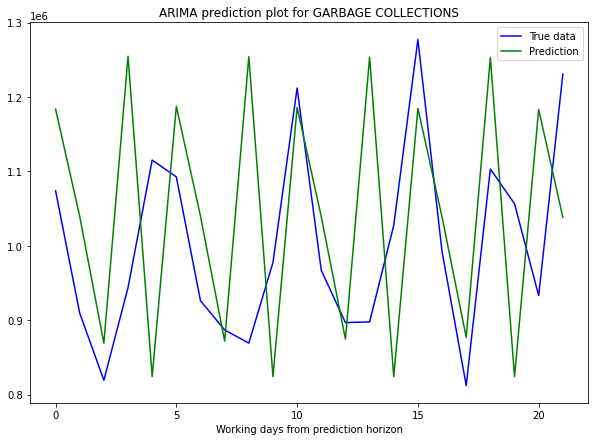

## 👓 References

[1] https://www.sciencedirect.com/science/article/abs/pii/S0956053X18307268

[2] https://www.sciencedirect.com/science/article/abs/pii/S0956053X19301692

[3] https://download.bbbike.org/osm/bbbike/Austin/Austin.osm.pbf 

[4] https://wiki.openstreetmap.org/wiki/OpenLayers_osm_file_example

[5] https://docs.osmcode.org/pyosmium/latest/ref_osm.html

[6] https://wiki.openstreetmap.org/wiki/Map_features

[7] https://github.com/njanakiev/worlddataleague-2021


